In [1]:
import cv2
import numpy as np
from scipy import ndimage

from matplotlib import pyplot as plt
from scipy import signal

import sys
np.set_printoptions(threshold=sys.maxsize)

# FUNCTION DEFINITIONS

In [2]:
def ee(LH: np.array, HL: np.array, p = 2):
    return np.sqrt(LH**p + HL**p)**(1/p)

In [3]:
def remove_isolated_px(img):
    image = img.copy()
    image_i = cv2.bitwise_not(image)
    
    kernel1 = np.array([[0, 0, 0],
                        [0, 1, 0],
                        [0, 0, 0]], np.uint8)
    kernel2 = np.array([[1, 1, 1],
                        [1, 0, 1],
                        [1, 1, 1]], np.uint8)


    hitormiss1 = cv2.morphologyEx(image, cv2.MORPH_ERODE, kernel1)
    hitormiss2 = cv2.morphologyEx(image_i, cv2.MORPH_ERODE, kernel2)
    hitormiss = cv2.bitwise_and(hitormiss1, hitormiss2)

    hitormiss_i = cv2.bitwise_not(hitormiss)
    return cv2.bitwise_and(image, image, mask=hitormiss_i) 

In [4]:
def ac_img_along_vec(img, vector: tuple, mean = None):
    if mean is None:
        mean = np.mean(img)
    shifted_img = np.roll(img, vector, (0,1))

    return (img - mean) * (shifted_img - mean)

    

# IMPORTING IMAGE

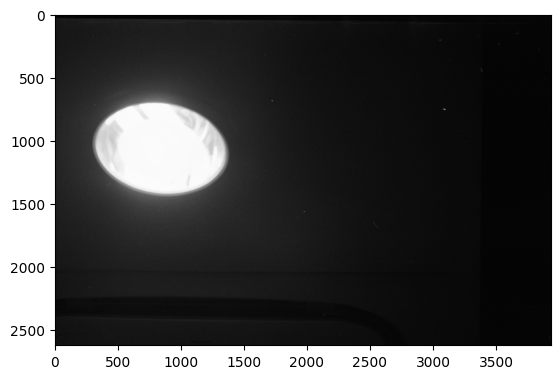

In [5]:
img = cv2.imread("res/img/101.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Bluring helps with very noisy images:
#img = cv2.medianBlur(img, 3)

plt.figure()
plt.imshow(img, cmap="gray")
plt.show()

## Edge detection using proposed algorithm

This is the filtering step to get energy map:

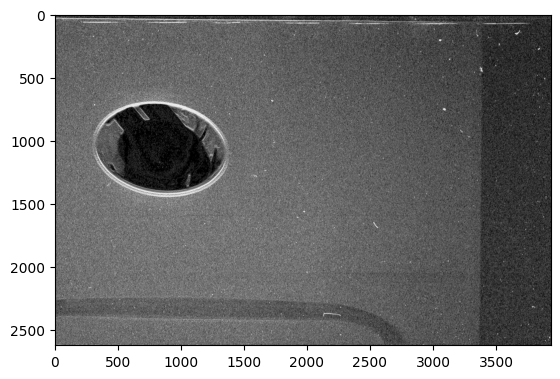

In [6]:
h = 0.125 * np.array([-1, 2, 6, 2, -1],     dtype=np.float32)
g1 = 0.5 * np.array([1, 0, -1],            dtype=np.float32)
g2 = 0.5 * np.array([1, 0, 0, 0, -1],      dtype=np.float32)
g3 = 0.5 * np.array([1, 0, 0, 0, 0, 0 -1], dtype=np.float32)

gs = [g1, g2, g3]
filters = []


for g in gs:
    filters.append(np.convolve(h, g))
    filters.append(np.convolve(h,np.flip(g)))

ees = []
for f in filters:
    imgh = cv2.filter2D(img, -1, f)
    imgv = cv2.filter2D(img, -1, f.T)
    ees.append(ee(imgh, imgv))

energy_map = np.zeros(ees[0].shape)
for e in ees:
    energy_map = np.maximum(energy_map, e)

#f1 = np.matrix(np.convolve(h, g1))
#imgf1h = cv2.filter2D(img, -1, f1)
#imgf1v = cv2.filter2D(img, -1, f1.T)
#ee1 = ee(imgf1h, imgf1v)

#f2 = np.matrix(np.convolve(h, g2))
#imgf2h = cv2.filter2D(img, -1, f2)
#imgf2v = cv2.filter2D(img, -1, f2.T)
#ee2 = ee(imgf2h, imgf2v)

#f3 = np.matrix(np.convolve(h, g3))
#imgf3h = cv2.filter2D(img, -1, f3)
#imgf3v = cv2.filter2D(img, -1, f3.T)
#ee3 = ee(imgf3h, imgf3v)

#print(f1, f2, f3)

#energy_map = np.maximum(np.maximum(ee1, ee2), ee3)

plt.figure()
plt.imshow(energy_map, cmap="gray")
plt.show()



Tresholding the map with all-at-once algorithm:

In [7]:
# Tresholding

img_thresh = np.floor(img*0.125)
img_thresh = np.array(img_thresh, dtype=np.uint8)

thresholds1 = np.full(32, 2.7, dtype=np.float32)
w = 10E-4
c = 2.5

for x in range(10):
    for value in range(32):
        mask = np.zeros(img.shape, dtype=np.uint8)
        mask[img_thresh==value] = 1
        thresholds1[value] = (1-w) * thresholds1[value] + w*c * np.mean(energy_map[mask==1])

thresholds1 = np.nan_to_num(thresholds1, nan=3)

thresholds1

array([2.6919246, 2.7029529, 2.7113698, 2.7150066, 2.7155836, 2.7161913,
       2.7167192, 2.717577 , 2.7199326, 2.722747 , 2.7251396, 2.7283506,
       2.7334478, 2.738854 , 2.741382 , 2.74279  , 2.7434223, 2.7466927,
       2.7488444, 2.750366 , 2.755242 , 2.7550623, 2.750105 , 2.7453923,
       2.7392046, 2.7220187, 2.7133207, 2.7134054, 2.7130868, 2.709277 ,
       2.702041 , 2.6801057], dtype=float32)

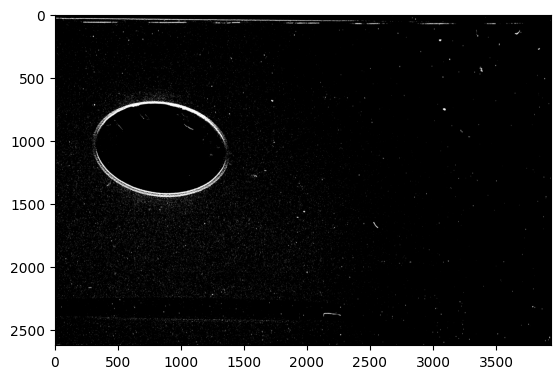

In [8]:
energy_map1 = energy_map.copy()
for val in range(32):
    energy_map1[img_thresh==val] = (energy_map1[img_thresh==val] > thresholds1[val])

plt.figure()
plt.imshow(energy_map1, cmap="gray")
plt.show()

Cleanup of isolated pixels:

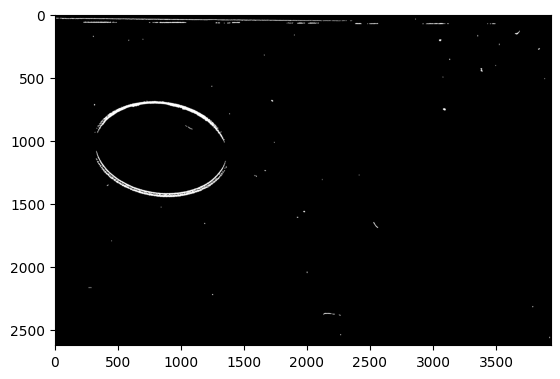

In [9]:
cleaned1 = cv2.medianBlur(np.array(energy_map1, dtype=np.uint8), 5)

nb_blobs, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(cleaned1)
sizes = stats[:, -1]
sizes = sizes[1:]
nb_blobs -= 1

min_size = 30

cleaned = np.zeros_like(im_with_separated_blobs)

for blob in range(nb_blobs):
    if sizes[blob] >= min_size:
        # see description of im_with_separated_blobs above
        cleaned[im_with_separated_blobs == blob + 1] = 255

plt.figure()
plt.imshow(cleaned, cmap="gray")
plt.show()

Using Canny just for fun:

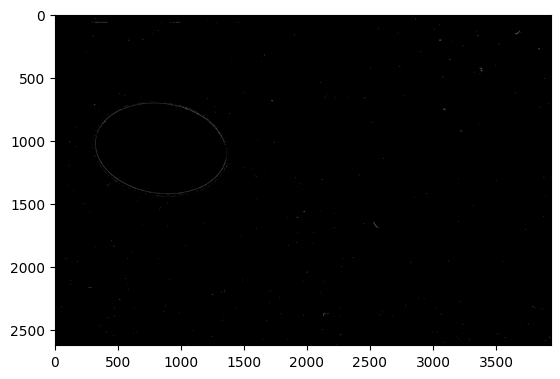

In [10]:
edges = cv2.Canny(img, 75, 90)
edges = remove_isolated_px(np.array(edges, dtype=np.uint8))

plt.figure()
plt.imshow(edges, cmap="gray")
plt.show()

### Dilating areas:

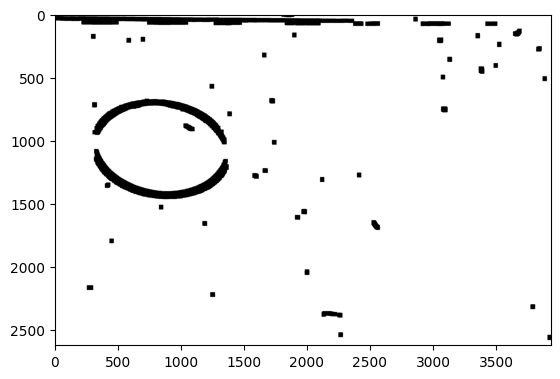

In [11]:
dilation_kernel = np.ones((31,31), dtype=np.uint8)
final_mask = cv2.dilate(np.array(cleaned, dtype=np.uint8), dilation_kernel, iterations=1)
final_mask = cv2.bitwise_not(final_mask)
final_mask[final_mask < 255] = 0

plt.figure()
plt.imshow(final_mask, cmap="gray")
plt.show()

Number of detected areas: 1


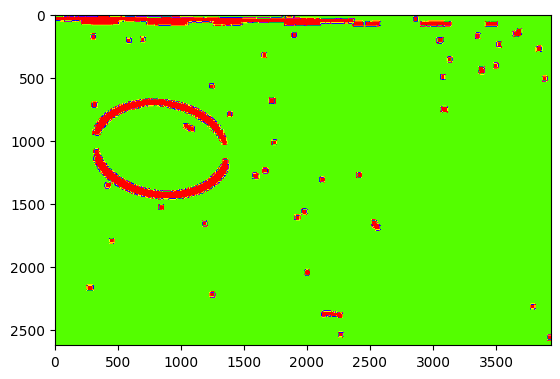

In [12]:
connectivity_map = np.ones((3,3), dtype=np.uint8)
areas, num_features = ndimage.label(final_mask, connectivity_map)

vals, counts = np.unique(areas, return_counts=True)
threshold = max(np.median(counts), 10000)
grain_area_indices = []
for val, cnt in zip(vals[1:], counts[1:]):
    if cnt > threshold:
        grain_area_indices.append(val)

print("Number of detected areas: {0}".format(len(grain_area_indices)))

plt.figure()
plt.imshow(areas, cmap="prism")
plt.show()

### Grain analysis:

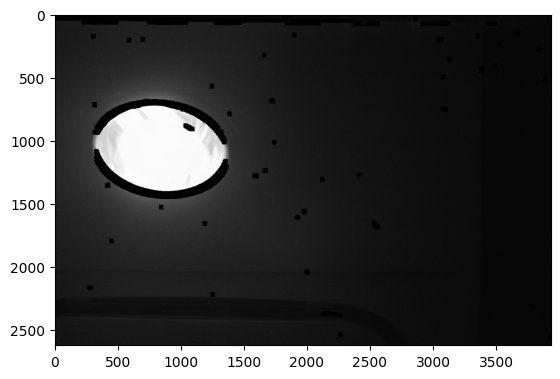

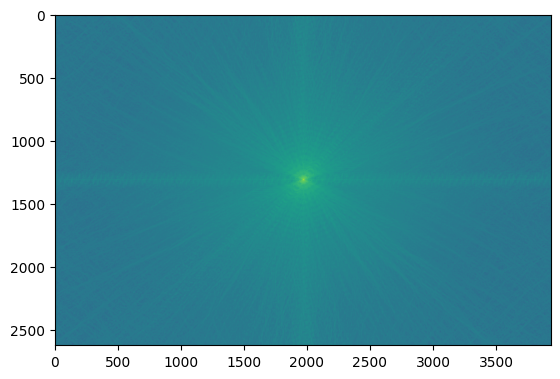

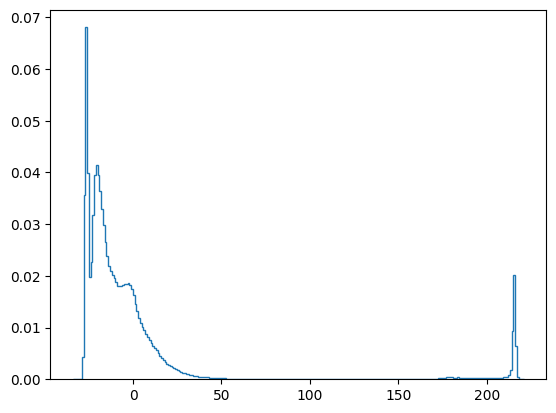

Noise minimum = 2.0
Noise median = 20.0
Noise mean = 33.967735290527344
Noise std = 50.95559310913086


In [13]:
id = grain_area_indices[0]

first_area = img.copy()
first_area = np.array(img, dtype=np.float32)
first_area[areas!=id] = -1

noise_min = np.min(first_area[areas==id])
noise_mean = np.mean(first_area[areas==id])
noise_median = np.median(first_area[areas==id])
noise_std  = np.std(first_area[areas==id])

plt.figure()
plt.imshow(first_area, cmap="gray")
plt.show()

only_noise = img.copy()
only_noise[areas!=id] = 0
fft_img = np.fft.fftshift(np.fft.fft2(only_noise))
plt.figure()
plt.imshow(np.log(abs(fft_img)))
plt.show()

hist, edges = np.histogram(first_area[areas==id], bins=256, range=(0,255))
hist = hist/np.sum(hist)
edges = edges-noise_mean
plt.figure()
plt.stairs(hist, edges)
plt.show()



print("Noise minimum = {0}\nNoise median = {1}\nNoise mean = {2}\nNoise std = {3}".format(noise_min, noise_median, noise_mean, noise_std))